# Etude des devices
Dans ce notebook, nous nous sommes intéressé à l'étude des devices, et donc plus particulièrement de la variable 'did'.

Nous avons pu mettre en évidence à travers l'etude que certains devices étaient plus problématiques que d'autres pendant la phase d'entrainement. 

Nous avons également montrer que retirer certains devices permettait d'améliorer les performnces de nos algorithmes. 

Nous avons donc retiré une partie des devices sur le jeu d'entrainement, mais nous n'avons pas affacté de le jeu de test. 


NB : Suite à cette étude, nous avons décidé d'écarter certains modèles, pour ne sélectionner que les meilleurs, et les utiliser en combinant les techniques de Bagging. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from IpyTools import *
from IotTools import *

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import train_test_split, KFold
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
df_mess_train = pd.read_csv('../mess_train_list.csv')
df_mess_test = pd.read_csv('../mess_test_list.csv')
pos_train = pd.read_csv('../pos_train_list.csv')

In [ ]:
X_train = df_mess_train
X_train.shape

(39250, 8)

In [ ]:
X_train= Correct_Bases(X_train)
X_train.shape

Nous avons 27 bases outliers


(39250, 11)

In [ ]:
listOfBs = np.union1d(X_train.bsid.unique(),df_mess_test.bsid.unique())
df_feat, id_list=feat_mat_const(X_train, listOfBs)
y_full = ground_truth_const(X_train, pos_train, id_list)
y_full.shape,df_feat.shape

((6068, 3), (6068, 273))

# Nous mettons en place une solution de OneDeviceOut afin de mettre en évidence des devices entrain une erreur dans l'entrainement.

[476248,476598,476889,476836,476896,476256,473897]

[476513., 476248., 476598., 476889., 473438., 476836., 476327.,476896., 476256., 473288., 473897.]

Run de la fonction avec un seul modèle

In [ ]:
%%time
devices = df_mess_train.did.unique()
kf = KFold(n_splits=len(devices), shuffle=True, random_state=0)

sol_Xb=[]
Ldevices=[]
for step, (train_index, test_index) in enumerate(kf.split(devices)):

    a = df_mess_train[df_mess_train.did.isin(devices[test_index])].messid.values

    X_split_test = df_feat[df_feat.index.isin(a)]
    y_split_test = y_full[y_full.messid.isin(a)]
    y_split_test
 
    b = df_mess_train[df_mess_train.did.isin(devices[train_index])].messid.values

    X_split_train = df_feat[df_feat.index.isin(b)]
    y_split_train = y_full[y_full.messid.isin(b)]
    y_split_train

    reg_lng = xgb.XGBRegressor()
    reg_lat = xgb.XGBRegressor()

    y_pred_lng= reg_lng.fit(X_split_train, y_split_train.lng).predict(X_split_test)
    y_pred_lat= reg_lat.fit(X_split_train, y_split_train.lat).predict(X_split_test)


    err_vec = Eval_geoloc(y_split_test.lat , y_split_test.lng, y_pred_lat, y_pred_lng)
    a=np.percentile(err_vec, 80)
    Ldevices.append(devices[test_index][0])
    sol_Xb.append(a)
    print(f"{step}/{len(devices)}:device : {int(devices[test_index][0])} qual: {a:.4}")

0/113:device : 476594 qual: 1.9
1/113:device : 476320 qual: 1.19
2/113:device : 476332 qual: 0.6661
3/113:device : 476314 qual: 2.767
4/113:device : 476513 qual: 13.75
5/113:device : 476315 qual: 2.731
6/113:device : 476861 qual: 3.853
7/113:device : 476225 qual: 0.3014
8/113:device : 473864 qual: 4.23
9/113:device : 476512 qual: 3.837
10/113:device : 476248 qual: 11.01
11/113:device : 476598 qual: 53.08
12/113:device : 476826 qual: 1.377
13/113:device : 1747434 qual: 1.181
14/113:device : 476140 qual: 1.192
15/113:device : 476280 qual: 0.7714
16/113:device : 477201 qual: 8.508
17/113:device : 476251 qual: 2.331
18/113:device : 476197 qual: 2.094
19/113:device : 476321 qual: 0.5671
20/113:device : 476889 qual: 13.94
21/113:device : 476253 qual: 4.494
22/113:device : 476325 qual: 5.594
23/113:device : 476609 qual: 1.977
24/113:device : 476306 qual: 4.154
25/113:device : 476161 qual: 3.171
26/113:device : 473892 qual: 2.149
27/113:device : 476307 qual: 4.025
28/113:device : 476286 qual: 

Mise en évidence des devices outliers

In [ ]:
sol=sol_Xb
sol=np.array(sol)
Ldevices=np.array(Ldevices)
Q2,Q3 = np.quantile(sol,[0.5,0.75])
#Valeur maximale (Quantile)
Qmax = Q3+(1.5*(Q3-Q2))
Qmax

7.2066807

{'whiskers': [<matplotlib.lines.Line2D at 0x29ea2938b80>,
 'caps': [<matplotlib.lines.Line2D at 0x29ea2950280>,
 'boxes': [<matplotlib.lines.Line2D at 0x29ea2938820>],
 'medians': [<matplotlib.lines.Line2D at 0x29ea2950940>],
 'fliers': [<matplotlib.lines.Line2D at 0x29ea2950ca0>],
 'means': []}

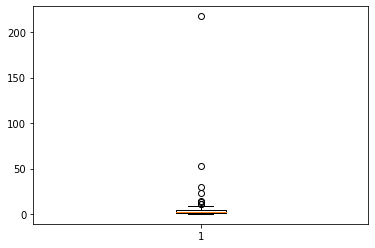

In [ ]:
plt.boxplot(sol_Xb)

In [ ]:
#Liste des indices ayant un scoring trop élevé          
c=np.where(sol>Qmax)
#Liste des scoring et des devices associés        
d=sol[c]
e=Ldevices[c]
#Liste dans l'ordre des scoring des devices à retirer.
f = zip(d[np.argsort(d)[::-1]],e[np.argsort(d)[::-1]])

Liste dans l'ordre des devices outliers

In [ ]:
for i,j in f:
    print(j,i)

473288.0 217.48987599999998
476598.0 53.0813708
476896.0 29.8495194
476256.0 23.205006200000003
476889.0 13.939934000000001
476513.0 13.745626
476248.0 11.006528
476327.0 10.636915
473897.0 9.064336
476836.0 8.565059600000012
477201.0 8.508052


La fonction permet de passer en revue tous les algorithmes testés et d'identifier tous les devices a retirer en fonction de l'erreur de prédiction leur étant associée.

In [ ]:
devices = df_mess_train.did.unique()
kf = KFold(n_splits=len(devices), shuffle=True, random_state=0)

def One_Device_Out(reg):

    sol=[]
    Ldevices=[]
    print(f"{len(devices)} >",end="")
    for step, (train_index, test_index) in enumerate(kf.split(devices)):

        a = df_mess_train[df_mess_train.did.isin(devices[test_index])].messid.values

        X_split_test = df_feat[df_feat.index.isin(a)]
        y_split_test = y_full[y_full.messid.isin(a)]

        b = df_mess_train[df_mess_train.did.isin(devices[train_index])].messid.values

        X_split_train = df_feat[df_feat.index.isin(b)]
        y_split_train = y_full[y_full.messid.isin(b)]

        reg_lng = reg()
        reg_lat = reg()

        y_pred_lng= reg_lng.fit(X_split_train, y_split_train.lng).predict(X_split_test)
        y_pred_lat= reg_lat.fit(X_split_train, y_split_train.lat).predict(X_split_test)

        err_vec = Eval_geoloc(y_split_test.lat , y_split_test.lng, y_pred_lat, y_pred_lng)
        a=np.percentile(err_vec, 80)
        Ldevices.append(devices[test_index][0])
        sol.append(a)
        print(f"{step} ",end="")
        #print(f"{step}/{len(devices)}:device : {int(devices[test_index][0])} qual: {a:.4}")
    print()
    sol=np.array(sol)
    Ldevices=np.array(Ldevices)
    Q2,Q3 = np.quantile(sol,[0.5,0.75])
    #Valeur maximale (Quantile)
    Qmax = Q3+(1.5*(Q3-Q2))
    #Liste des indices ayant un scoring trop élevé          
    c=np.where(sol>Qmax)
    #Liste des scoring et des devices associés        
    d=sol[c]
    e=Ldevices[c]
    #Liste dans l'ordre des scoring des devices à retirer.
    return e[np.argsort(d)[::-1]],d[np.argsort(d)[::-1]]

Appel de la fonction pour entrainer plusieurs modèles.\
Attention 1h de run

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor

print("RandomForestRegressor")
indice_Rdf,sol_Rdf = One_Device_Out(RandomForestRegressor)
print(f"min: {np.min(sol_Rdf)},mean: {np.mean(sol_Rdf)},max: {np.max(sol_Rdf)},Nb outliers: {len(list(indice_Rdf))}")

print("XGBRegressor")
indice_Xbg,sol_Xbg = One_Device_Out(xgb.XGBRegressor)
print(f"min: {np.min(sol_Xbg)},mean: {np.mean(sol_Xbg)},max: {np.max(sol_Xbg)},Nb outliers: {len(list(indice_Xbg))}")

print("GradientBoostingRegressor")
indice_Gbr,sol_Gbr = One_Device_Out(GradientBoostingRegressor)
print(f"min: {np.min(sol_Gbr)},mean: {np.mean(sol_Gbr)},max: {np.max(sol_Gbr)},Nb outliers: {len(list(indice_Gbr))}")

print("Adaboost")#retiré
indice_Ada,sol_Ada = One_Device_Out(AdaBoostRegressor)
print(f"min: {np.min(sol_Ada)},mean: {np.mean(sol_Ada)},max: {np.max(sol_Ada)},Nb outliers: {len(list(indice_Ada))}")

print("BaggingRegressor")
indice_Bag,sol_Bag = One_Device_Out(BaggingRegressor)
print(f"min: {np.min(sol_Bag)},mean: {np.mean(sol_Bag)},max: {np.max(sol_Bag)},Nb outliers: {len(list(indice_Bag))}")

print("ExtraTreesRegressor")
indice_Etr,sol_Etr = One_Device_Out(ExtraTreesRegressor)
print(f"min: {np.min(sol_Etr)},mean: {np.mean(sol_Etr)},max: {np.max(sol_Etr)},Nb outliers: {len(list(indice_Etr))}")


RandomForestRegressor
113 >0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 
min: 10.377766000000001,mean: 26.401500520000003,max: 87.369069,Nb outliers: 10
XGBRegressor
113 >0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 
min: 8.508052,mean: 36.28111118181818,max: 217.48987599999998,Nb outliers: 11
GradientBoostingRegressor
113 >0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

On identifie la liste des device a retirer pour optimiser le gain de chaque modèle.

In [ ]:
clf=RandomForestRegressor()
for i in range(1,len(indice_Rdf)+1):
    df_feat, id_list=feat_mat_const(X_train[~X_train.did.isin(indice_Xbg[:i])], listOfBs)
    y_full = ground_truth_const(X_train[~X_train.did.isin(indice_Xbg[:i])], pos_train, id_list)
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"{i}: {np.percentile(err_vec, 80)}")
indice=8

1: 3.1815408000000023
2: 3.1114103999999996
3: 3.1221864
4: 3.084866
5: 3.09567
6: 3.10403
7: 3.1426985999999997
8: 2.861524
9: 2.902416
10: 2.9017744000000016


In [ ]:
clf=xgb.XGBRegressor()
sol=[]
for i in range(1,len(indice_Xbg)+1):
    df_feat, id_list=feat_mat_const(X_train[~X_train.did.isin(indice_Xbg[:i])], listOfBs)
    y_full = ground_truth_const(X_train[~X_train.did.isin(indice_Xbg[:i])], pos_train, id_list)
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    sol.append(np.percentile(err_vec, 80))
    print(f"{i}: {np.percentile(err_vec, 80)}")
indice=10

1: 3.2999476000000016
2: 3.3149246
3: 3.2762046
4: 3.319474
5: 3.2003096000000006
6: 3.201966
7: 3.1876609999999994
8: 3.1740676000000008
9: 3.153909
10: 3.1646416000000004
11: 3.169305


In [ ]:
clf=GradientBoostingRegressor()
for i in range(1,len(indice_Gbr)+1):
    df_feat, id_list=feat_mat_const(X_train[~X_train.did.isin(indice_Xbg[:i])], listOfBs)
    y_full = ground_truth_const(X_train[~X_train.did.isin(indice_Xbg[:i])], pos_train, id_list)
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"{i}: {np.percentile(err_vec, 80)}")
indice=9

1: 3.1716592000000094
2: 3.118464200000001
3: 3.109275600000002
4: 3.092489
5: 3.0448432
6: 3.037039
7: 3.0392674
8: 2.9709876
9: 2.964013
10: 2.9379772000000015
11: 2.93558


In [ ]:
clf=BaggingRegressor()
for i in range(1,len(indice_Bag)+1):
    df_feat, id_list=feat_mat_const(X_train[~X_train.did.isin(indice_Xbg[:i])], listOfBs)
    y_full = ground_truth_const(X_train[~X_train.did.isin(indice_Xbg[:i])], pos_train, id_list)
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"{i}: {np.percentile(err_vec, 80)}")
indice=10

1: 3.3118488
2: 3.3922858
3: 3.3422382
4: 3.25946
5: 3.2562298000000003
6: 3.22591
7: 3.268358399999999
8: 3.0302180000000005
9: 3.048601
10: 2.9233632000000016
11: 3.077237
12: 2.967907


In [ ]:
clf=ExtraTreesRegressor()
for i in range(1,len(indice_Etr)+1):
    df_feat, id_list=feat_mat_const(X_train[~X_train.did.isin(indice_Xbg[:i])], listOfBs)
    y_full = ground_truth_const(X_train[~X_train.did.isin(indice_Xbg[:i])], pos_train, id_list)
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"{i}: {np.percentile(err_vec, 80)}")
indice=8

1: 3.118585800000001
2: 3.1291994
3: 3.0974074000000007
4: 3.111786
5: 3.1318127999999996
6: 3.043922
7: 3.1125435999999995
8: 2.8823604000000005
9: 2.815256
10: 2.850886600000002
11: 2.881282
12: 2.909212


In [ ]:
clf=AdaBoostRegressor()
for i in range(1,len(indice_Ada)+1):
    df_feat, id_list=feat_mat_const(X_train[~X_train.did.isin(indice_Xbg[:i])], listOfBs)
    y_full = ground_truth_const(X_train[~X_train.did.isin(indice_Xbg[:i])], pos_train, id_list)
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"{i}: {np.percentile(err_vec, 80)}")

1: 9.9226942
2: 8.3115048
3: 9.047787
4: 8.319671
5: 7.086263000000001
6: 8.168882
7: 8.3895974


In [ ]:
indice_Rdf[:11],indice_Xbg[:11],indice_Gbr[:10],indice_Bag[:9],indice_Etr[:13]

(array([473288., 476598., 476256., 476836., 476513., 476896., 476889.,
        476248., 476327., 473897.]),
 array([473288., 476598., 476896., 476256., 476889., 476513., 476248.,
        476327., 473897., 476836., 477201.]),
 array([473288., 476598., 476256., 476896., 476889., 476513., 476836.,
        476248., 473897., 476525.]),
 array([473288., 476598., 476256., 476889., 476513., 476248., 476896.,
        476836., 476197.]),
 array([473288., 476598., 476896., 476256., 476889., 476513., 476248.,
        476836., 476327., 473897., 476835., 476891.]))

3 jeux de device a tester.

In [ ]:
a=[473288,476598,476256,476896,476889,476513,476836,476248]
b=[473288,476598,476256,476896,476889,476513,476836,476248,473897,476835]
c=[473288,476598,476256,476896,476889,476513,476836,476248,473897,476835,476327]

In [ ]:
for i in [a,b,c]:

    df_feat, id_list=feat_mat_const(X_train[~X_train.did.isin(i)], listOfBs)
    y_full = ground_truth_const(X_train[~X_train.did.isin(i)], pos_train, id_list)

    clf=RandomForestRegressor()
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"Rfr : {np.percentile(err_vec, 80)}")
    clf=xgb.XGBRegressor()
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"Xgb : {np.percentile(err_vec, 80)}")
    clf=GradientBoostingRegressor()
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"Gbr : {np.percentile(err_vec, 80)}")
    clf=BaggingRegressor()
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"Gr : {np.percentile(err_vec, 80)}")
    clf=ExtraTreesRegressor()
    y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
    y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
    err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
    print(f"Etr : {np.percentile(err_vec, 80)}")

Rfr : 3.151398
Xgb : 3.1823174
Gbr : 3.0450302000000002
Gr : 3.1943300000000012
Etr : 3.1049222
Rfr : 3.0811139999999995
Xgb : 3.210776599999999
Gbr : 3.0077228
Gr : 3.3097658
Etr : 3.103739
Rfr : 2.8574196
Xgb : 3.0375768
Gbr : 2.8986162
Gr : 2.9825766
Etr : 2.8860664


In [ ]:
#a:
Rfr = 3.1759198
Xgb = 3.1214306000000005
Gbr = 3.0772756
Gr = 3.311634
Etr = 3.1265218000000004
(Rfr+Xgb+Gbr+Gr+Etr)/5

3.1625563600000004

In [ ]:
#b:
Rfr = 3.0811295999999997
Xgb = 3.168285
Gbr = 3.0522896
Gr =3.3121332
Etr = 3.105744799999999
(Rfr+Xgb+Gbr+Gr+Etr)/5

3.1439164399999995

In [ ]:
#c:
Rfr = 2.8675715999999998
Xgb = 2.986346
Gbr = 2.9246252000000004
Gr = 3.0738478000000002
Etr = 2.8881852000000006
(Rfr+Xgb+Gbr+Gr+Etr)/5

2.94811516

Au final on ne gardera que 2 modèles et on refera un jeux de device pour eux uniquement

In [ ]:
indice_Xbg[:8],indice_Etr[:8]

(array([473288., 476598., 476896., 476256., 476889., 476513., 476248.,
        476327.]),
 array([473288., 476598., 476896., 476256., 476889., 476513., 476248.,
        476836.]))

In [ ]:
d=[76598,476896,476256,476513,476889,476248,473288,476327,476836]

In [ ]:
df_feat, id_list=feat_mat_const(X_train[~X_train.did.isin(d)], listOfBs)
y_full = ground_truth_const(X_train[~X_train.did.isin(d)], pos_train, id_list)

clf=xgb.XGBRegressor()
y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
print(f"Xgb : {np.percentile(err_vec, 80)}")

clf=ExtraTreesRegressor()
y_pred_lng_RF = cross_val_predict(clf, df_feat, y_full.lng, cv=3)
y_pred_lat_RF = cross_val_predict(clf, df_feat, y_full.lat, cv=3)
err_vec = Eval_geoloc(y_full.lat , y_full.lng, y_pred_lat_RF, y_pred_lng_RF)
print(f"Etr : {np.percentile(err_vec, 80)}")

Xgb : 3.0369544000000004
Etr : 2.893951600000001
